# <font color=yellow> Payment Automation </font>

The sample is intended to demonstrate how the standard process of payment management can be automatized using Kyriba APIs.<br>
Please see below the schema of the standard payment workflow.

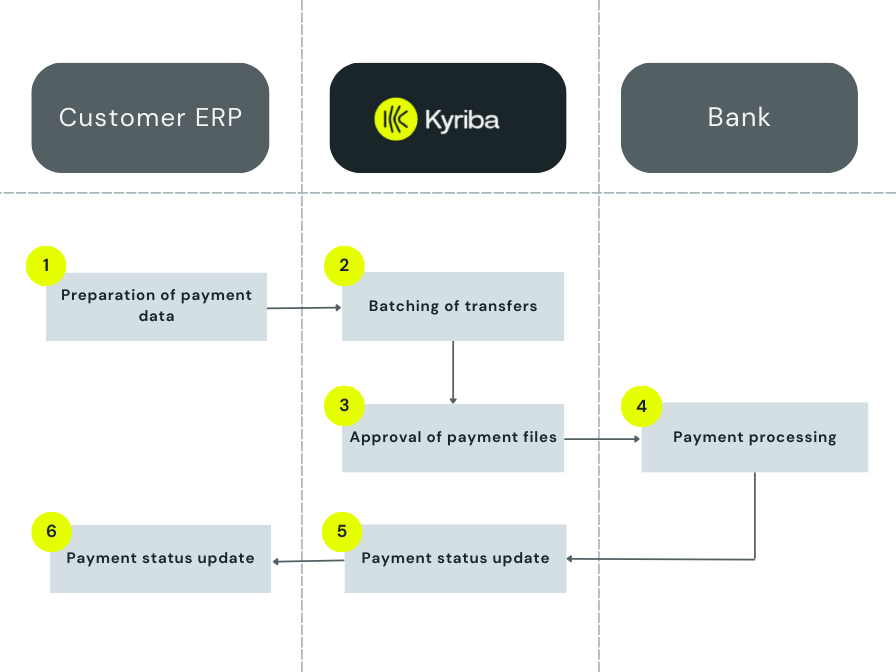

## <font color='yellow'>Step 0.1: Code for token generation and API management</font>
      

In [ ]:
#@title Select **servicePack** the Sample should run
from subprocess import getstatusoutput
servicePack = 'DEMO' #@param ['DEMO'] {allow-input: true}

if servicePack == 'DEMO':
  branch = 'main'
else:
  branch = servicePack
print(branch)
rm = getstatusoutput("rm Colab_shared_code_for_API_usage -rf ") 
clone = getstatusoutput("git clone -l -s --branch " +  branch + " https://github.com/kyriba/Colab_shared_code_for_API_usage.git") 
import importlib

enableFormatterDF = True #@param {type:"boolean"}
from google.colab import data_table

if enableFormatterDF is True:
  data_table.enable_dataframe_formatter()
else:
  data_table.disable_dataframe_formatter()

try:  
  importlib.reload(sample_requests)
except:
  print()
  
from Colab_shared_code_for_API_usage import sample_requests

main



In [ ]:
#@title Import custom modules
import time
from datetime import datetime,date
import json as js


## <font color='yellow'>Step 0.2: Connect and  retrieve token</font>

In [ ]:
#@title <font color='lime'>Connect</font>
print('token:')
token = sample_requests.login()

token:
token 06741356-e1b4-4941-9b27-20380f18e4e7


## <font color='yellow'>Step 1: Preparation of payment data</font>


In [ ]:
#@title <font color='lime'>Fill in the form with payment data</font>
#@markdown Enter transaction date, amount, and reference.\
#@markdown Please ensure **reference** is unique to avoid duplicates.\
#@markdown Select **paymentMultiplier** to simulate generation of multiple payments (up to 1,000).\
#@markdown Select **paymentGroups** to split the transactions into groups (up to 5).


transactionDate = "2023-01-23" #@param {type:"date"}
amount = 10 #@param {type:"number"}
reference = "USECASE_TESTXX" #@param {allow-input: true, type: "string"}
paymentMultiplier = 6 #@param {type:"slider", min:1, max:1000, step:1}
paymentGroups = 2 #@param {type:"slider", min:1, max:5, step:1}
#@markdown ---
traces = False #@param {type:"boolean"}

PET = "ST_PET"
today = date.today()
now = datetime.now()
dt_string = str(today) + 'T' + now.strftime("%H:%M:%S")

transformedDate = transactionDate[8:10] + transactionDate[5:7] + transactionDate[0:4] 
paymentsLeft = paymentMultiplier
counter = 1
filenames = dict()
references = []

for i in range(paymentGroups, 0, -1):
  data = ""
  transNum = paymentsLeft // i
  for j in range(transNum):
    data_in = ";" + transformedDate + ";" + str(amount) + ";;" + PET + ";" + reference + "_" + str(counter) + "\r\n"
    references.append(reference + "_" + str(counter))
    data += data_in
    counter += 1
    paymentsLeft -= 1
  
  filename = dt_string + "-Gr" + str(paymentGroups - i + 1) + "-Tr" + str(transNum) + "-" + reference + ".csv"
  filenames[filename] = ''

  if traces:
    print('data:\r\n' + data)
    print('\r\nreference:' + reference)

  res = sample_requests.import_data(token, data, filename,'DEMO_PY_AP', True, traces)
  print('\r\ndata pushed to Kyriba Application: ' + filename)


In [ ]:
#@title <font color='lime'>(OPTIONAL) Launch report on rejections in case of warning / error</font>
res = sample_requests.run_report(token,'DEMO_PY_REJ')
buffer = sample_requests.StringIO(res[3:])
df4 = sample_requests.pd.read_csv(buffer,skiprows=[0,1],header=0)
df4_out = df4[df4['Reference'].str.startswith(reference)]
df4_out.reset_index(drop=True, inplace=True)
display(df4_out)

In [ ]:
#@title <font color='lime'>Launch report on integrated transfers</font>
import pandas as pd
res2 = sample_requests.run_report(token,'PY_EXP2')
buffer = sample_requests.StringIO(res2)
df2 = sample_requests.pd.read_csv(buffer,delimiter=';',usecols=[0,3,5,6,7,8,9,10,12],names=['transaction number', 'status','payor','debit account','transaction date','amount','third-party','reference', 'origin'],header=None)
df2 = df2.loc[df2['reference'].str.startswith(reference)]
df2.sort_values(['origin'], inplace=True)
df2.reset_index(drop=True, inplace=True)
df2.index = df2.index + 1
display(df2)

## <font color='yellow'>Step 2: Batching of transfers</font>


In [ ]:
#@title <font color='lime'>Automatic batching</font> { display-mode: "form" }

sample_requests.run_process(token,'DEMO_BATCH_API', True)


In [ ]:
#@title <font color='lime'>Get remittance ID and status</font> { display-mode: "form" }

next_act = {'CONSTITUTED' : 'Generate the bank file',
            'GENERATED' : 'Monitor the file approval / Transmit',
            'TO_BE_DELETED': 'Delete the remittance',
            'TO_BE_MODIFIED': 'Modify the remittance',
            'PUSHED_TO_COMMUNICATION_CHANNEL': 'Wait for answer',
            'TRANSMITTED' : 'None'}

res3 = sample_requests.run_report(token,'PY_EXP2')
buffer = sample_requests.StringIO(res3)
df3 = sample_requests.pd.read_csv(buffer,delimiter=';',usecols=[0,3,5,6,7,8,9,10,12,13],names=['transaction number', 'status','payor','debit account','transaction date','amount','third-party','reference', 'origin', 'batchID'],header=None)

#display(df3)

for fn in filenames:
  get_request = '/v1/payment/transfers/status?filter=fileName==' + fn
  get_response = sample_requests.get_results(token, get_request)
  results = js.loads(get_response)['results']
  try:
    current_status = results[0]['remittance']['status']
    print('\033[93mFilename: ' + fn)
    print('Remittance ID: ' + results[0]['remittance']['batchId'])
    print('Remittance status: ' + current_status)
    print('Next action: ' + next_act[current_status] + '\x1b[0m')

    df_tmp = df3.loc[df3['origin'] == 'PYImport/' + fn]
    df_tmp.reset_index(drop=True, inplace=True)
    df_tmp.index = df_tmp.index + 1
    display(df_tmp)
    print('\n')
  except TypeError:
    print('\033[91mTransfers from the file \033[1;4m' + fn + '\x1b[0m\033[91m have not been batched yet.')
    print('Please launch the batch process.\x1b[0m\n')
  except IndexError:
    print('\033[91mTransfers from the file \033[1;4m' + fn + '\x1b[0m\033[91m have not been integrated.')
    print('Please check the report on rejections (Step 1).\x1b[0m\n')


## <font color='yellow'>Step 3: Approval of payment files</font>
# <font size="4">This step can only be done manually in the Kyriba Application. Approval workflow is disabled for the purpose of this use case.</font>


## <font color='yellow'>Step 4: Payment processing</font>
# <font size="4">Bank processes the payment files and sends payment status reports (PSR) back to Kyriba.</font>


## <font color='yellow'>Step 5: Kyriba - Payment status update</font>
# <font size="4">Once PSR is received, the payment status is updated in the Kyriba Application.</font>


## <font color='yellow'>Step 6: Customer ERP - Payment status update</font>
# <font size="4">Once updated in the Kyriba Application, the status of transactions and batches can be retrieved via API.</font>


In [ ]:
import ipywidgets as widgets


#@title <font color='lime'>Select transaction or batch</font> { display-mode: "form" }
#@markdown Please select the level you would like to check the status at:
level =  "Transaction" #@param ["Transaction", "Batch"]  {allow-input: false}
#@markdown Run the form and select **Reference** for transaction level and **Filename** for batch level from the dropdown list below.

if level == "Transaction":
  dropdown = widgets.Dropdown(
      options=references,
      description='Reference:',
      disabled=False
  )
elif level == "Batch":
  dropdown = widgets.Dropdown(
      options=filenames.keys(),
      description='Filename:',
      disabled=False
  )
display(dropdown)

In [ ]:
#@title <font color='lime'>Get status of transaction or batch</font> { display-mode: "form" }

if level == "Transaction":
  get_request = '/v1/payment/transfers/status?filter=reference==' + dropdown.value + ';fileName==' + dt_string + '*'
elif level == "Batch":
  get_request = '/v1/payment/transfers/status?filter=fileName==' + dropdown.value

get_response = sample_requests.get_results(token, get_request)

try:
  results = js.loads(get_response)['results']

  try:
    if level == "Transaction":
      print('Transaction number: ' + results[0]['transactionNumber'])
      print('Reference: ' + results[0]['reference'])
      print('Transaction Status: ' + results[0]['status'])
      print('Transaction Next action: ' + results[0]['nextAction'])
    elif level == "Batch":
      print('Filename: ' + dropdown.value)

    print('\n')
    print('Remittance ID: ' + results[0]['remittance']['batchId'])
    print('Remittance status: ' + results[0]['remittance']['status'])

  except TypeError:
    print('\033[93mRemittance ID: Transfer has not been batched yet.')
    print('Remittance status: Please launch the batch process.\x1b[0m')
  except IndexError:
    print('\033[91mTransfers from the file \033[1;4m' + fn + '\x1b[0m\033[91m have not been integrated.')
    print('Please check the report on rejections (Step 1).\x1b[0m\n')

except TypeError:
  print('\n\033[91mPlease enter reference in the form.\x1b[0m')
